In [36]:
import random, numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torchvision.transforms as xforms, torchvision.datasets, torchvision.utils
import matplotlib.pyplot as plt, matplotlib.animation as animation
import PIL
import pdb
import IPython.display
from torchvision import datasets, models, transforms
from torchvision.models.resnet import BasicBlock
from tqdm.auto import tqdm

The critic: (taken from lecture)

In [2]:
class Critic(nn.Module):
    def __init__(self, feat_dim=64):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, feat_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim, feat_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim * 2, feat_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim * 4, feat_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        def init_layer(layer):
            if layer.__class__.__name__[:4] == 'Conv':
                nn.init.normal_(layer.weight, 0.0, 0.02)
            elif layer.__class__.__name__[:9] == 'BatchNorm':
                nn.init.normal_(layer.weight, 1.0, 0.02)
                nn.init.constant_(layer.bias, 0.0)

        self.layers.apply(init_layer)

        
    def forward(self, input):
        return self.layers(input)

The generator: (modified from lecture)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        vgg = torchvision.models.vgg11(pretrained=True)
        # freezing all vgg layers
        for param in vgg.parameters():
            param.requires_grad = False
        # the three convolution layers pre-trained from vgg11
        self.conv_layers = nn.Sequential(
            vgg.features[0],
            vgg.features[1],
            nn.InstanceNorm2d(64),
            vgg.features[3],
            vgg.features[4],
            nn.InstanceNorm2d(128),
            vgg.features[6],
            vgg.features[7],
            nn.InstanceNorm2d(256)
        )

        # 9 resnet blocks
        self.resnet_layers = nn.Sequential(
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
        )

        # the 3 transposed convolution layers
        self.tconv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Sigmoid()
        )

        def init_layer(layer):
            if layer.__class__.__name__[:4] == 'Conv':
                nn.init.normal_(layer.weight, 0.0, 0.02)
            elif layer.__class__.__name__[:9] == 'BatchNorm':
                nn.init.normal_(layer.weight, 1.0, 0.02)
                nn.init.constant_(layer.bias, 0.0)

        self.tconv_layers.apply(init_layer)

        
    def forward(self, samples):
        # pass sample through all the layers
        #pdb.set_trace()
        out = self.conv_layers(samples)
        out = self.resnet_layers(out)
        out = self.tconv_layers(out)
        return out

Testing generator with random inputs

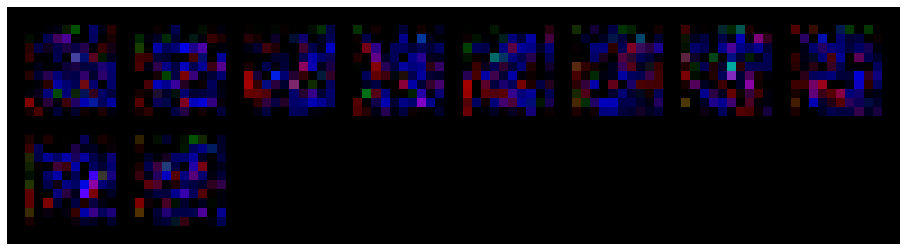

In [8]:
gen = Generator()
fake_samples = gen(torch.randn(10, 3, 10, 10))
plt.figure(figsize=(16,8)); plt.axis('off')
plt.imshow(torchvision.utils.make_grid(fake_samples.detach().cpu(), normalize=True).permute(1,2,0))

Training code: (taken from lecture)

In [10]:
def run_train(model_gen, model_crit, ds, crit, opt_gen, opt_crit, dev, n_epochs=10, batch_sz=32, ref=None):
    model_gen = model_gen.to(dev)
    model_crit = model_crit.to(dev)
    model_gen.train()
    model_crit.train()
    ldr = torch.utils.data.DataLoader(ds, batch_size=batch_sz)

    tq_epochs = tqdm(range(n_epochs), desc='epochs', unit='ep')
    for epoch_no, epoch in enumerate(tq_epochs):
        tq_iters = tqdm(ldr, desc='iter')    
        for samples in tq_iters:
            model_crit.zero_grad()
            batch_sz = samples[0].size(0)
            with torch.no_grad():
                for param in model_crit.parameters():
                    param.clamp_(-0.01, 0.01)
                    
            samples = samples[0].to(dev)
            labels = torch.full((batch_sz,), 1, dtype=torch.float, device=dev)
            outs = model_crit(samples).squeeze()
            real_loss = crit(outs, labels)
            real_loss.backward()

            priors = torch.randn(batch_sz, 3, 64, 64, device=dev)   # inputting random data to the generator just to test it
            fakes = model_gen(priors)
            labels.fill_(0)
            outs = model_crit(fakes.detach()).squeeze()
            fake_loss = crit(outs, labels)
            fake_loss.backward()

            crit_loss = real_loss + fake_loss
            opt_crit.step()

            model_gen.zero_grad()
            labels.fill_(1)
            outs = model_crit(fakes).squeeze()
            gen_loss = crit(outs, labels)
            gen_loss.backward()
            opt_gen.step()
        
        if ref is not None:
            ref_priors, ref_imgs = ref
            ref_fakes = model_gen(ref_priors.to(dev)).detach().cpu()
            ref_imgs.append(torchvision.utils.make_grid(ref_fakes, normalize=True))

Testing only 1 generator and 1 critic with some data

In [5]:
!wget -N http://courses.ece.ubc.ca/cpen291/l8-gan/celebA-small.zip
!unzip -n -q celebA-small.zip

--2021-03-29 03:45:45--  http://courses.ece.ubc.ca/cpen291/l8-gan/celebA-small.zip
Resolving courses.ece.ubc.ca (courses.ece.ubc.ca)... 142.103.83.164
Connecting to courses.ece.ubc.ca (courses.ece.ubc.ca)|142.103.83.164|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘celebA-small.zip’ not modified on server. Omitting download.



In [43]:
ds = torchvision.datasets.ImageFolder(root='celebA-small',
                                      transform=xforms.Compose([
                                          xforms.CenterCrop(64),
                                          xforms.ToTensor()
                                      ]))
dataset = torch.utils.data.Subset(ds, np.random.choice(len(ds), 1000, replace=False))
len(dataset)

1000

In [44]:
device = torch.device('cuda:0')
#device = torch.device('cpu')

ref_fake_imgs = []
ref_priors = torch.randn(32, 3, 64, 64, device=device)

model_gen = Generator()
model_crit = Critic()
crit = nn.BCELoss()
opt_gen = optim.RMSprop(model_gen.parameters(), lr=1e-4)
opt_crit = optim.RMSprop(model_crit.parameters(), lr=1e-4)

In [ ]:
model_gen

The training code runs,

In [45]:
run_train(model_gen, model_crit, dataset, crit, opt_gen, opt_crit, device, n_epochs=10, ref=(ref_priors,ref_fake_imgs))

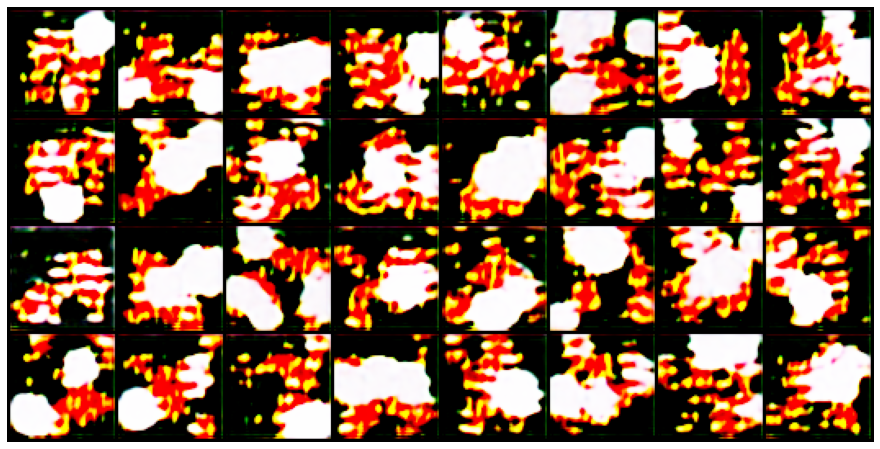

In [46]:
fig = plt.figure(figsize=(16,8)); plt.axis('off')
frames = [[plt.imshow(img.permute(1,2,0), animated=True)] for img in ref_fake_imgs]
anim = animation.ArtistAnimation(fig, frames, interval=1000, repeat_delay=1000, blit=True)
IPython.display.HTML(anim.to_jshtml())